# Feature Extraction (Keypoint Features)

**Author**: Maleakhi Agung Wijaya  
**Email**: maw219@cam.ac.uk  
**Description**: This file contains code for extracting keypoint features. Particularly, we consider SIFT, BRIEF, and ORB. Subsequently, we further pre-process these keypoints and feature descriptors using bag of visual words and compare their discriminative capabilities by training various ML models.

In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import plotly.express as px
import plotly.graph_objects as go
import scipy.io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
import pickle
from scipy.spatial.distance import cdist

# Images
import os
import cv2
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.style as style
from skimage.io import imread, imshow
import re

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models, backend as K, callbacks

In [30]:
%run Utilities.ipynb

## Load and Preprocess Dataset

This section load shell images one-by-one. We primarily explore and preprocess the dataset in this section

In [33]:
filenames = sorted(os.listdir(SHELL_IMAGES_DATA))
X_species, y_species = preprocess_x_y(filenames)

# Test outputs
print(X_species[0])
print(y_species[0])

('Aandara_consociata_10_A.jpg', 'Aandara_consociata_10_B.jpg')
Aandara_consociata


Aandara_consociata


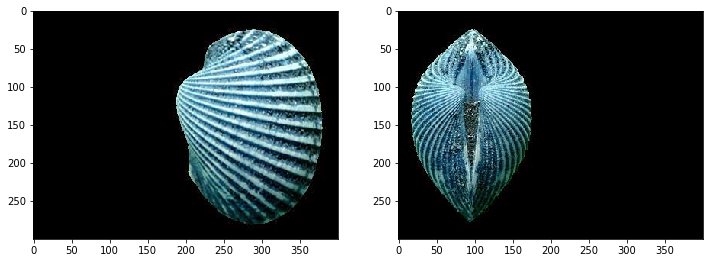

In [32]:
# Test visualise image
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
print(y_species[0])
image1 = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_species[0][0]))
image2 = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_species[0][1]))
ax1.imshow(image1)
ax2.imshow(image2)

plt.show()

## SIFT

This section conduct feature extraction using SIFT.

### Feature Extraction  

In [34]:
X_sift = []
y_sift = y_species
sift = cv2.xfeatures2d.SIFT_create()

# Get feature descriptors from all images
for X in tqdm(X_species):
    X_a = X[0] # A position
    X_b = X[1]
    
    # Open the image in gray scale
    image_a = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_a),
                   cv2.IMREAD_GRAYSCALE)
    image_b = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_b),
                   cv2.IMREAD_GRAYSCALE)
    
    kp_a, descriptors_a = sift.detectAndCompute(image_a, None)
    kp_b, descriptors_b = sift.detectAndCompute(image_b, None)
    
    X_sift.append((descriptors_a, descriptors_b))

In [35]:
# Concatenate rear and front view keypoints
X_sift_concatenate = [] # concatenated version of X_sift, considering front and rear views at once
for x in X_sift:
    X_sift_concatenate.append(np.concatenate((x[0], x[1])))

### Visualisation  

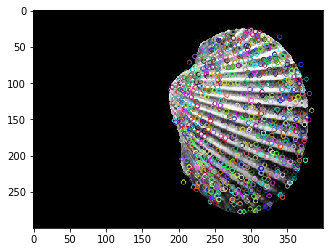

In [36]:
image1 = cv2.imread(os.path.join(SHELL_IMAGES_DATA, X_species[0][0]),
                   cv2.IMREAD_GRAYSCALE)
sift = cv2.xfeatures2d.SIFT_create()
kp, descriptors = sift.detectAndCompute(image1, None) # can add mask
img = cv2.drawKeypoints(image1, kp, None)
plt.imshow(img)
plt.show()

### Bag of Visual Words

In [ ]:
## Build dictionary of visual words
# Concatenate all keypoints
X_sift_full = np.vstack(X_sift_concatenate)

# Build vocabulary of differing sizes
vocabulary_sizes = [100, 500, 1000] # we already have 200
for size in vocabulary_sizes:
    kmeans = KMeans(n_clusters=size)
    kmeans.fit(X_sift_full)
    filename = f"../results/vocab_{size}.pickle"
    save_object(kmeans, filename)

In [12]:
## Load dictionary
kmeans_100 = load_object("../results/vocab_100.pickle")
vocab_100 = kmeans.cluster_centers_

kmeans_200 = load_object("../results/vocab_200.pickle")
vocab_200 = kmeans.cluster_centers_

kmeans_500 = load_object("../results/vocab_500.pickle")
vocab_500 = kmeans.cluster_centers_

kmeans_1000 = load_object("../results/vocab_1000.pickle")
vocab_1000 = kmeans.cluster_centers_

In [ ]:
# Build histograms
X_100 = build_histograms(vocab_100, 100, X_species)
X_200 = build_histograms(vocab_200, 200, X_species)
X_500 = build_histograms(vocab_500, 500, X_species)
X_1000 = build_histograms(vocab_1000, 1000, X_species)

# Whiten results
scaler = StandardScaler()
X_100_scaled = scaler.fit_transform(X_100)
X_200_scaled = scaler.fit_transform(X_200)
X_500_scaled = scaler.fit_transform(X_500)
X_1000_scaled = scaler.fit_transform(X_1000)

### Classification

#### Standard ML Models

The following consider SVC and random forest.